In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import time

from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential

import pathlib

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
data_dir = "gdrive/My Drive/vehicle_images"

In [4]:
start_training = time.time()

In [5]:
batch_size = 32
img_height = 180
img_width = 180

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

class_names = train_dataset.class_names
print(class_names)

Found 4333 files belonging to 4 classes.
Using 3467 files for training.
Found 4333 files belonging to 4 classes.
Using 866 files for validation.
['bus', 'motorcycle', 'plane', 'train']


(32, 180, 180, 3)
(32,)


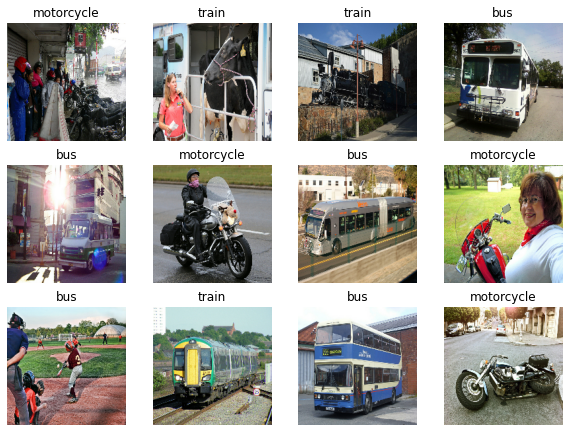

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

for image_batch, labels_batch in train_dataset:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

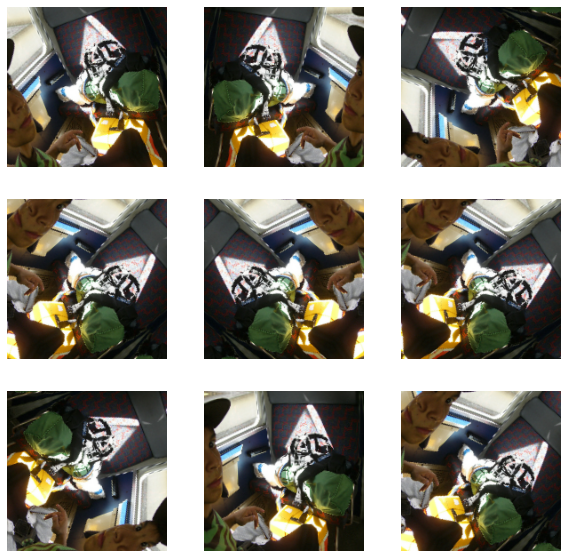

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),])


for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size = AUTOTUNE)

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_dataset))
first_image = image_batch[0]

## Notice the pixels values are now in '[0, 1]'
print(np.min(first_image), np.max(first_image))

num_classes = 4   

0.0 0.9995916


In [9]:
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width, 3)),
                    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
                    layers.AveragePooling2D(),
                    layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
                    layers.AveragePooling2D(),
                    layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
                    layers.AveragePooling2D(),
                    layers.Flatten(),
                    layers.Dense(128, activation = 'relu'),
                    layers.Dense(num_classes)
])

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 average_pooling2d (AverageP  (None, 90, 90, 16)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 average_pooling2d_1 (Averag  (None, 45, 45, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)       

In [10]:
epochs= 10
history = model.fit(train_dataset, validation_data = val_dataset, epochs=epochs)


accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range = range(epochs)

Epoch 1/10
109/109 [==============================] - 167s 1s/step - loss: 1.2869 - accuracy: 0.3963 - val_loss: 1.1329 - val_accuracy: 0.5058
Epoch 2/10
109/109 [==============================] - 3s 25ms/step - loss: 1.0917 - accuracy: 0.5281 - val_loss: 1.0159 - val_accuracy: 0.5727
Epoch 3/10
109/109 [==============================] - 3s 23ms/step - loss: 1.0117 - accuracy: 0.5723 - val_loss: 0.9715 - val_accuracy: 0.5820
Epoch 4/10
109/109 [==============================] - 3s 23ms/step - loss: 0.9387 - accuracy: 0.6129 - val_loss: 0.9543 - val_accuracy: 0.6097
Epoch 5/10
109/109 [==============================] - 2s 23ms/step - loss: 0.8547 - accuracy: 0.6588 - val_loss: 0.9346 - val_accuracy: 0.6374
Epoch 6/10
109/109 [==============================] - 3s 23ms/step - loss: 0.7463 - accuracy: 0.7101 - val_loss: 0.9816 - val_accuracy: 0.6062
Epoch 7/10
109/109 [==============================] - 3s 23ms/step - loss: 0.6018 - accuracy: 0.7698 - val_loss: 1.0593 - val_accuracy: 0.5970

In [11]:
end_training = time.time()

time_to_train = end_training - start_training
time_to_train

856.1894268989563

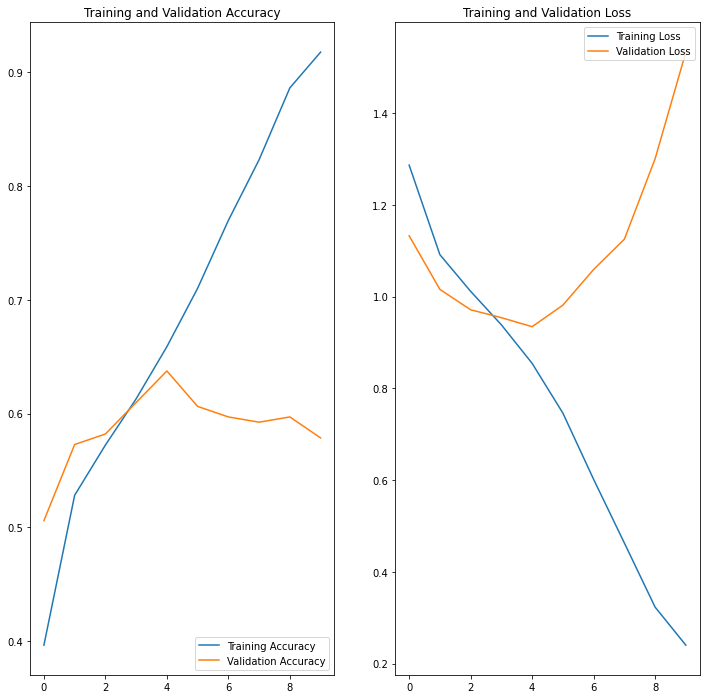

In [12]:
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
new_data_dir = "gdrive/My Drive/vehicle_pictures"
batch_size = 32
img_height = 180
img_width = 180
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    new_data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = test_dataset.class_names
print(class_names)

Found 20 files belonging to 4 classes.
['Bus', 'Motorcycle', 'Plane', 'train']


In [15]:
loss, accuracy = model.evaluate(test_dataset)
print('Test Accuracy: ', accuracy)

1/1 [==============================] - 3s 3s/step - loss: 2.3357 - accuracy: 0.6500
Test Accuracy:  0.6499999761581421
